Source from GAMES101: https://sites.cs.ucsb.edu/~lingqi/teaching/games101.html

Transformation: from world object to screen 

three steps: 

1. MVP transformation
2. ViewPort transformation
3. Rasterization

# 1.MVP transformation
- Model tranformation + View tranformation
    - Let the camera(e in the figure) to be the origin

![image](./figure/0-1.png)

- Projection tranformation
    - orthographic 
    - perspective

![image](./figure/0-2.png)


### Model+View transformation

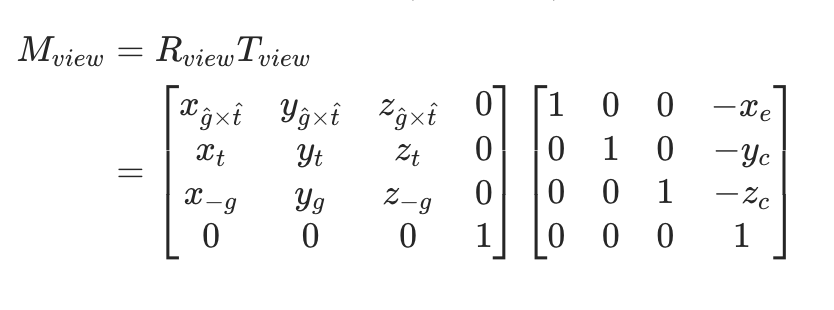

### Perspective Projection

- transform to orthographic 
- then apply orthographic projection(ndc coordinate): $[-1,1]^3$

![image.png](./figure/0-3.png)

In [17]:
import numpy as np

class Camera:
    def __init__(self, e, t, g, frustum) -> None:
        self.e = e
        self.t = t 
        self.g = g
        self.frustum = frustum # [t,b,l,r,n,f]
        
        # M_view     
        self.T = np.array([ [1,0,0,-self.e[0]],
                            [0,1,0,-self.e[1]],
                            [0,0,1,-self.e[2]],
                            [0,0,0,1]])
                      
        gt = np.cross(self.g, self.t)
        self.R = np.array([ [gt[0],gt[1],gt[2],0],
                            [self.t[0],self.t[1],self.t[2],0],
                            [-self.g[0],self.g[1],-self.g[2],0],
                            [0,0,0,1]]) 
        self.view = np.dot(self.R, self.T)
    
        # M_per
        t,b,l,r,n,f = self.frustum[0], self.frustum[1], self.frustum[2], self.frustum[3], self.frustum[4], self.frustum[5]
        self.Persp = np.array([ [2*n/(r-l),0,(l+r)/(l-r),0],
                                [0,2*n/(t-b),(b+t)/(b-t),0],
                                [0,0,(f+n)/(n-f),2*f*n/(f-n)],
                                [0,0,1,0]])

Put the camera and object(a triangle) in the world space

![image](./figure/0-4.png)

In [19]:
myCamera = Camera(e=[1,0,0], g=[0,0,-1], t=[0,1,0], frustum=[1,-1,-1,1,-2,-6])
triangle = {"A": np.array([0,-1,-4,1]), "B": np.array([2,-1,-4,1]), "C": np.array([1,1,-6,1])}

# 2.ViewPort transformation

$[-1,1]^3->[0,W]\times[0,H]$

In [27]:
# Screen
H = 100
W = 100
screen = np.zeros([H, W, 3])

def ViewScreen(triangle_ndc, H, W): # [H, W] is the screen resolution
    triangle_screen = np.zeros([3, 2])
    for i, node in enumerate(["A","B","C"]):
        triangle_screen[i][0] = (0.5*triangle_ndc[node][0]+0.5)*W
        triangle_screen[i][1] = (0.5*triangle_ndc[node][1]+0.5)*H
    return triangle_screen

# 3.Rasterization

**Sample** at the center of the pixel: whether the center is in the triangle

Note that the the array direction(orange) is different from axis(red)

![image](./figure/0-5.1.png)

In [ ]:
def whether_in_triangle(triangle_screen, Q):
    # whether coodinate Q is in the triangle?
    # AB×AQ, BC×BQ, CA×CQ point to same side of the screen(sign(z) are same) ->  Q in triangle
    A = np.append(triangle_screen[0], [0], axis=0) 
    B = np.append(triangle_screen[1], [0], axis=0)
    C = np.append(triangle_screen[2], [0], axis=0)
    Q = np.append(Q, [0], axis=0)
    x1 = np.cross(B-A, Q-A)
    x2 = np.cross(C-B, Q-B)
    x3 = np.cross(A-C, Q-C)
    if np.sign(x1[2]) == np.sign(x2[2]) == np.sign(x3[2]):
        return True
    else:
        return False

In [51]:
import imageio
from time import time
def normalize(a):
    a = np.array([a[0]/a[3], a[1]/a[3], a[2]/a[3], a[3]/a[3]])
    return a

# Project object in world space to NDC space ([-1,1]^3)
triangle_ndc = {}
for i in ["A","B","C"]:
    # to camera space
    triangle_c = np.dot(myCamera.view, triangle[i])
    # to ndc space
    triangle_ndc[i] = normalize(np.dot(myCamera.Persp, triangle_c))

# Screen info
H = 100
W = 100
screen = np.zeros([H, W, 3])

# NDC space to screen space
triangle_screen = ViewScreen(triangle_ndc, H, W) # shape=[3,2]

t0 = time()
for i in range(W):
    for j in range(H):
        idx = j
        idy = H-i
        if whether_in_triangle(triangle_screen, [idx+0.5, idy+0.5]):
            screen[i][j] = [1,0,0] # the array direction is different axis
imageio.imsave("./result/0/triangle_origin.png", screen)
print(f"Time cost: {time()-t0}")

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Time cost: 0.8983030319213867


### Bounding box
![image](./figure/0-6.png)

In [48]:
# Screen info
H = 100
W = 100
screen = np.zeros([H, W, 3])

# triangle_screen: shape=[3,2]
x_left = int(min(triangle_screen[0][0], triangle_screen[1][0], triangle_screen[2][0]))
x_right = int(max(triangle_screen[0][0], triangle_screen[1][0], triangle_screen[2][0]))
y_bottom = int(min(triangle_screen[0][1], triangle_screen[1][1], triangle_screen[2][1]))
y_top = int(max(triangle_screen[0][1], triangle_screen[1][1], triangle_screen[2][1]))
t0 = time()
for i in range(y_bottom, y_top+1):
    for j in range(x_left, x_right+1):
        idx = j
        idy = H-i
        if whether_in_triangle(triangle_screen, [idx+0.5, idy+0.5]):
            screen[i][j] = [1,0,0]
imageio.imsave("./result/0/triangle_bounding_box.png", screen)
print(f"Time cost for using bounding box: {time()-t0}")

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Time cost for using bounding box: 0.21692895889282227


### MSAA

Problem: Artifacts, Alias

Solution:  Multi Sampling Anti-Aliasing

![image](./figure/0-7.png)

In [53]:
super_rate = 4 

# Screen info
H = 100
W = 100
screen = np.zeros([H, W, 3])
t0 = time()
for i in range(y_bottom, y_top+1):
    for j in range(x_left, x_right+1):
        idx = j
        idy = H-i
        count = 0
        for inter_idx in range(super_rate):
            for inter_idy in range(super_rate):
                if whether_in_triangle(triangle_screen, [idx+(2*inter_idx+1)/(2*super_rate), idy+(2*inter_idy+1)/(2*super_rate)]):
                    count += 1
        screen[i][j] = [count/(super_rate*super_rate),0,0]

import imageio
imageio.imsave(f"./result/0/triangle_MSAA_{super_rate}.png", screen)
print(f"Time cost for {super_rate} upsampling: {time()-t0}")

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Time cost for 4 upsampling: 2.981654644012451
